In [3]:
from sympy import init_session
init_session()

IPython console for SymPy 1.0 (Python 2.7.12-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.0/


In [4]:
from sympy.abc import rho
rho, u, c, h = symbols('rho u c h')

In [5]:
plus = u + c                                                                                                
zero = u                                                                                                    
minus = u - c                                                                                               
                                                                                                            
class Eigenvector(object):                                                                                  
    def __init__(self, name, ev, r, l=None):                                                                
        self.name = name
        if name == "minus":
            self.d = -1
        elif name == "zero":
            self.d = 0
        elif name == "plus":
            self.d = 1
        else:
            self.d = None
            
        self.ev = ev                                                                                        
        self.l = l                                                                                          
        self.r = r                                                                                          
                                                                                                            
    def __lt__(self, other):                                                                                
        return self.d < other.d                                                                            
                                                                                                            
    def __str__(self):                                                                                      
        return "{} wave, r = {}, l = {}".format(self.eigenvalue, self.r, self.l)  
    
def eigensystem(A):                                                                                         
    # get the left and right eigenvectors that diagonalize the system.                                      
    # it is best to use sympy diagonalize() for this purpose than getting                                   
    # the left and right eigenvectors independently.                                                        
                                                                                                            
    e = []                                                                                                  
                                                                                                            
    R, D = A.diagonalize()                                                                                  
                                                                                                            
    # the columns of R are the right eigenvectors and the diagonal                                          
    # element of D is the corresponding eigenvalues                                                         
                                                                                                            
    for n in range(A.shape[0]):                                                                             
        r = R.col(n)                                                                                        
        ev = D[n,n]                                                                                         
                                                                                                            
        # which eigenvalue are we?                                                                          
        if simplify(ev - minus) == 0:                                                                 
            name = "minus"                                                                                  
        elif simplify(ev - plus) == 0:                                                                
            name = "plus"                                                                                   
        elif simplify(ev - zero) == 0:                                                                
            name = "zero"                                                                                   
        else:                                                                                               
            return None                                                                                     
                                                                                                            
        # normalize the right eigenvector                                                                   
        v = r[0]                                                                                            
        if v != 0:                                                                                          
            r = r/v                                                                                         
                                                                                                            
        e.append(Eigenvector(name=name, ev=ev, r=r))                                                        
                                                                                                            
    # now sort the system from smallest (u-c) to largest (u+c)                                              
    e.sort()                                                                                                
                                                                                                            
    # now let's construct the R with this sorting                                                           
    for n in range(A.shape[0]):                                                                             
        R[:,n] = e[n].r                                                                                     
                                                                                                            
    # the left eigenvector matrix, L, is just the inverse                                                   
    L = R**-1                                                                                               
                                                                                                            
    for n in range(A.shape[0]):                                                                             
        e[n].l = L.row(n)      
        
    return e

# Euler Equations with $(\rho e)$

The Euler equations in primitive variable form, $q = (\rho, u, p, (\rho e))^\intercal$ appear as:
\begin{align}
\frac{\partial \rho}{\partial t} &= -u \frac{\partial \rho}{\partial x} - \rho \frac{\partial u}{\partial x} \\
\frac{\partial u}{\partial t} &= -u \frac{\partial u}{\partial x} - \frac{1}{\rho} \frac{\partial p}{\partial x} \\
\frac{\partial p}{\partial t} &= -u \frac{\partial p}{\partial x} - \rho c^2 \frac{\partial u}{\partial x} \\
\frac{\partial (\rho e)}{\partial t} &= -u \frac{\partial (\rho e)}{\partial x} - \rho h \frac{\partial u}{\partial x} 
\end{align}

In vector form, we have:
$$q_t + A(q) q_x = 0$$

with the matrix $A(q)$:


$$A(q) = \left ( \begin{array}{cccc} u  & \rho     & 0    & 0\\                          
                                  0  &  u       & 1/\rho  & 0\\                     
                                  0  & \rho c^2 & u       & 0\\
                                  0  & \rho h & 0       & u\end{array} \right )  
$$

The sound speed is related to the adiabatic index, $\Gamma_1$, as $c^2 = \Gamma_1 p /\rho$.

We can represent this matrix symbolically in SymPy and explore its eigensystem.

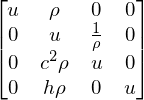

In [6]:
A = Matrix([[u, rho, 0, 0], [0, u, rho**-1, 0], [0, c**2 * rho, u, 0], [0, rho*h, 0, u]])
A

The eigenvalues are the speeds at which information propagates with.  SymPy returns them as a
dictionary, giving the multiplicity for each eigenvalue.

In [7]:
A.eigenvals()

We see that there are 2 eigenvalues $u$ -- the addition of $(\rho e)$ to the system adds this degeneracy.

## Eigenvectors

The right eigenvectors are defined for a given eigenvalue, $\lambda$, as:
$$A r = \lambda r$$
and the left eigenvectors satisfy:
$$l A = \lambda l$$

Note that the left and right eigenvectors are orthogonal to those corresponding to a different eigenvalue, and usually normalized so:
$$l^i \cdot r^j = \delta_{ij}$$

In [8]:
# we use the helper rountines above to find the orthogonal left and right eigenvectors
eigen = eigensystem(A)

minus


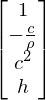

zero


zero


plus


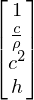

In [9]:
# printing them out for inspection
from sympy.printing.mathml import mathml
for e in eigen:
    print(e.name)
    display(e.r, e.l)

## $\beta$'s

The tracing projects the primitive variables into characteristic variables by defining
$$
\Delta q = \left ( \begin{array}{c} \Delta \rho \\ \Delta u \\ \Delta p \\ \Delta (\rho e) \end{array} \right )
$$
and then
$\beta^\nu = l^\nu \cdot \Delta q$

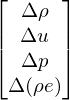

In [18]:
from sympy.abc import delta

dr = symbols(r"\Delta\rho")
du = symbols(r"\Delta{}u")
dp = symbols(r"\Delta{}p")
dre = symbols(r"\Delta(\rho{}e)")

dq = Matrix([[dr, du, dp, dre]]).transpose()
dq

minus


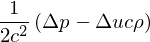

zero


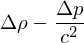

zero


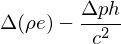

plus


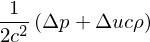

In [22]:
for e in eigen:
    print e.name
    beta = e.l.dot(dq)
    display(simplify(beta))

# 2-d system

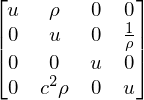

In [8]:
rho, u, v, c = symbols('rho u v c')

A = Matrix([[u, rho, 0, 0], [0, u, 0, rho**-1], [0,0, u, 0], [0, c**2 * rho, 0, u]])
A

In [9]:
A.eigenvals()

In [10]:
R = A.eigenvects()   # this returns a tuple for each eigenvector with multiplicity -- unpack it
r = []
lam = []
for (ev, _, rtmp) in R:
    for rv in rtmp:
        r.append(rv)
        lam.append(ev)
    
# we can normalize them anyway we want, so let's make the first entry 1
for n in range(len(r)):
    v = r[n]
    if not v[0] == 0:
        r[n] = v/v[0]

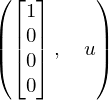

In [11]:
r[0], lam[0]

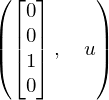

In [12]:
r[1], lam[1]

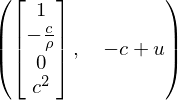

In [13]:
r[2], lam[2]

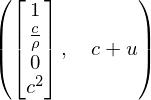

In [14]:
r[3], lam[3]

In [24]:
from sympy.abc import delta

dr = symbols(r"\delta\rho")

In [25]:
dr